#Project 3 | Clustering on Stellar Data





Collaborators:
*   Abhay Sharma
  * Data Preperation (Importing/Cleaning/Addressing Data Bias/PCA Reduction)
  * OPTICS clustering w/ writeup
  * DBSCAN clustering w/ writeup
  * HDBSCAN clustering w/ writeup
  * KMeans clustering w/ writeup
*   Jasmine O'Neal
  *   Gaussian Mixture Model w/ writeup

*  Akib Hossain
  * Conclusion Questions



#Data Preperation:

## Importing the Data:

In [1]:
!git clone https://github.com/AbhaySh4r/ML-AstroSet

Cloning into 'ML-AstroSet'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 37), reused 45 (delta 16), pack-reused 0
Receiving objects: 100% (84/84), 9.66 MiB | 13.16 MiB/s, done.
Resolving deltas: 100% (37/37), done.


## Cleaning and Preparing the Data:

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("ML-AstroSet/data/star_classification.csv")
df = df.replace(to_replace=-9999.0, value = np.nan)
df = df.dropna()

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_cont = df.drop("class", axis = 1)
norm_df = pd.DataFrame(scaler.fit_transform(df_cont))

norm_df.columns = df_cont.columns

### Rescaling and Addressing Data Bias:



<Axes: ylabel='class'>

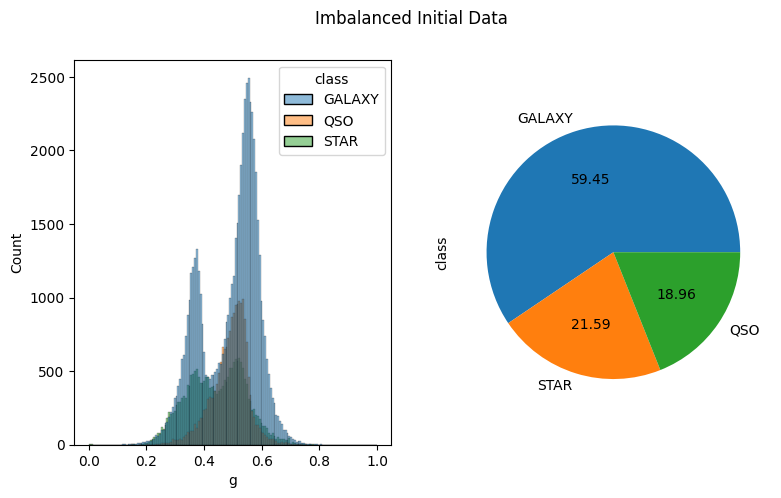

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plot = norm_df.join(df["class"])
fig, axis = plt.subplots(1,2, figsize = (9,5))
fig.suptitle("Imbalanced Initial Data")
autopct = "%.2f"

sns.histplot(plot, x = "g", hue = "class", ax= axis[0])
df["class"].value_counts().plot.pie(autopct=autopct, ax= axis[1])

We can see that there is a large imbalance in the dataset, with a significantly larger repersentation of Galaxy datapoints than any other class. We can utilize under/over sampling to mitigate this class imbalance and attempt to build more robust clustering models.

We will choose undersampling in the interest of keeping the overall size of the dataset small, since large datasizes might inflate computational time.

In [4]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
norm_undersamp, y_undersamp = rus.fit_resample(norm_df, df["class"])

<Axes: ylabel='class'>

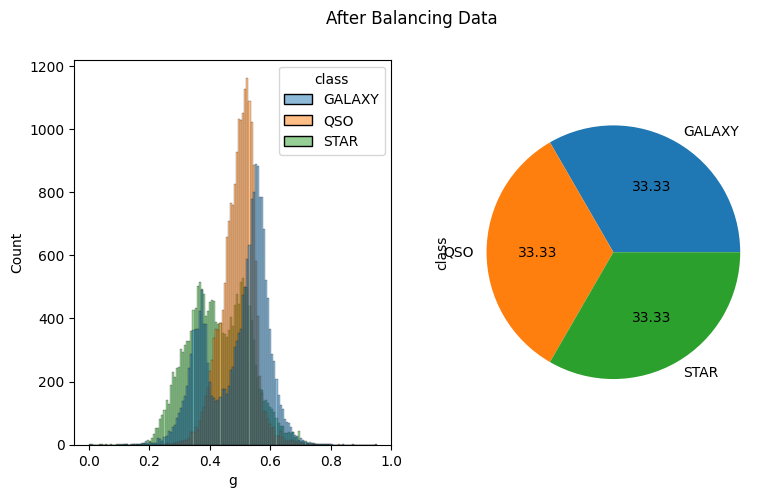

In [ ]:
plot = norm_undersamp.join(y_undersamp)
fig, axis = plt.subplots(1,2, figsize = (9,5))
fig.suptitle("After Balancing Data")
autopct = "%.2f"

sns.histplot(plot, x = "g", hue = "class", ax= axis[0])
y_undersamp.value_counts().plot.pie(autopct=autopct, ax= axis[1], title = "")

We can see that the data is more evenly balanced, and more importantly, the underlying trends from the undersampled GALAXY class are still represented within the data, comparing with the previous histogram.

### Principle Component Analysis:

Given that our dataset is large, we can use PCA to pick out the relevant features within our data to reduce complexity and computational time for for complex clustering algorithms

In [5]:
from sklearn.decomposition import PCA

norm_undersamp = norm_undersamp.loc[:, ~norm_undersamp.columns.isin(["obj_ID", "run_ID", "rerun_ID", "field_ID", "spec_obj_ID", "plate", "fiber_ID", "cam_col", "MJD", "alpha", "delta"])]

pca = PCA(n_components= 0.95, svd_solver="full")

X_reduc = pd.DataFrame(pca.fit_transform(norm_undersamp))

Many of the features that are taken out by hand are identifying information that are irrelevant to the physical features found by stellar objects. By removing these features we can prevent any of the models from cheating with using ID tags as a qualifying physical feature, and instead focus on clustering by the physical traits for each object.

We also retroactively removed "alpha" and "delta" as clustering algorithms were grouping objects by coordinates, rather than by physical traits. While not incorrect, it would be ultimately useless when it came to identifying out the 3 seperate classes of Stars/QSOs/Galaxies.

## Selecting Parameters and Generating Test/Train Sets:

In [6]:
from sklearn.model_selection import train_test_split

phys_df = X_reduc

X = phys_df
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y_undersamp, test_size=0.2, random_state=25)

Clustering algorithms don't actually need the test/train split, but we used it to test algorithms with a smaller subset of the data due to how some of the algorithms scaled with dimensional complexity.

#Clustering Algorithms:





<Axes: xlabel='1', ylabel='2'>

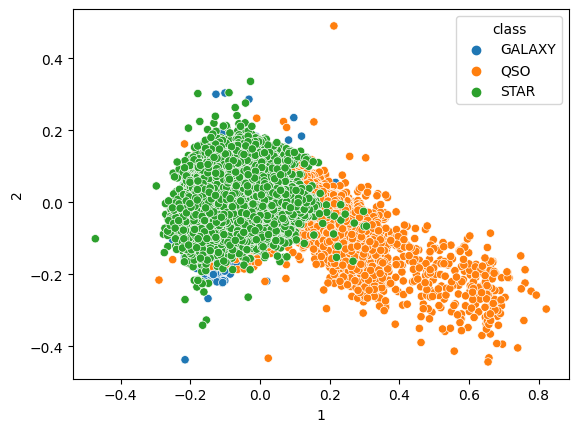

In [ ]:
baseline = X.join(y_undersamp)

sns.scatterplot(x = 1, y = 2,hue = "class", data = baseline)

This represents the baseline clustering within the data, so we can compare against this when analyzing clustering models.

## OPTICS (Ordering Points to Identify the Clustering Structure):
---

In [ ]:
from sklearn.cluster import OPTICS

MinPts = 100
max_eps = 0.04

op = OPTICS(min_samples = MinPts, cluster_method = "xi", max_eps = max_eps)
op.fit(X_reduc)

OPTICS(max_eps=0.04, min_samples=100)

In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X, op.labels_)
print("Silhouette Score:", score)

Silhouette Score: 0.45298289651215007


Text(0.5, 1.0, 'Reachability Plot')

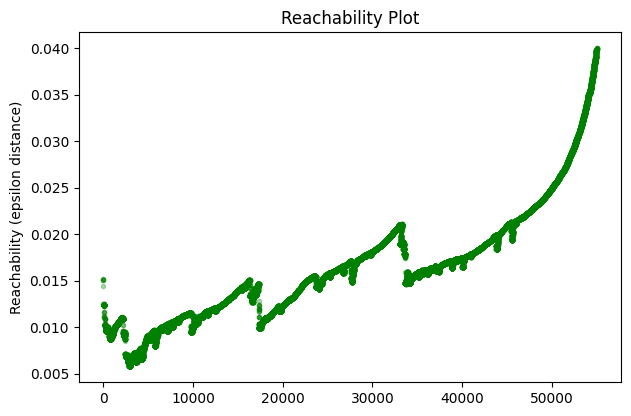

In [ ]:
from matplotlib import gridspec
import matplotlib.pyplot as plt

space = np.arange(len(X_reduc))
reachability = op.reachability_[op.ordering_]
labels = op.labels_[op.ordering_]

colors = ["g.", "r.", "b.", "c."]

plt.figure(figsize=(7, 10))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])

for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)

ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")



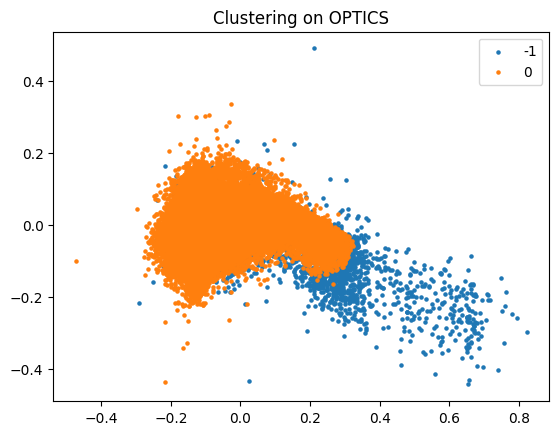

In [ ]:
labels = op.labels_

u_labels = np.unique(labels)

for i in u_labels:
  filterlabel = X_reduc[labels==i]
  plt.scatter(filterlabel[1], filterlabel[2], s = 5, label = i)

plt.title("Clustering on OPTICS")
plt.legend()
plt.show()

In [ ]:
#sc = []

#for y in np.arange(0.1, 1, 0.1):
#    for x in np.arange(0.01, 0.2, 0.01, dtype = float):

#        op = OPTICS(min_samples = x, cluster_method = "xi", max_eps=y)
#        op.fit(X_reduc)

#        try:
#            score = silhouette_score(X_reduc, op.labels_)
#        except ValueError as e:
#            score = "Error"



#        data = (y, x, score)
#        sc.append(data)

OPTICS did end up struggling developing a good clustering output. The initial claim of not having to specify an Epsilon radius was enticing when initially developing the algorithm, but the density of the data made it difficult to actually perform and generate good clusters.

While the sillhouette score demonstrates some reasonable clustering at 0.46, the overall performance leaves something to be desired. OPTICS did however provide a means of mass iterating through hyperparameters to then utilize and fine tune within the DBSCAN algorithm, visualized within the commented code above.

## Clustering using DBSCAN:
---

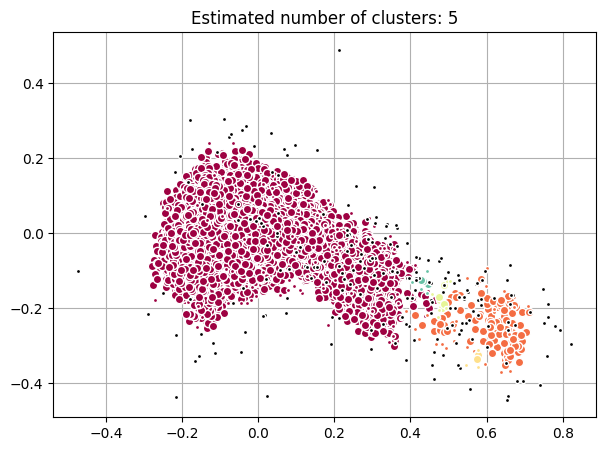

In [ ]:
from sklearn.cluster import DBSCAN

#This code is piecemealed from ICA-4

index1 = 1
index2 = 2

X2 = pd.DataFrame((X_reduc[index1], X_reduc[index2])).transpose()

#3 clusters at min 10, eps 0.05
#5 clusters at min 5, eps 0.046

data = X2
minpts = 5
eps = 0.046

db = DBSCAN(eps=eps, min_samples=minpts).fit(X_reduc)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# mark the samples that are considered "core"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

plt.figure(figsize=(7,5))
unique_labels = set(labels) # the unique labels
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = data[class_member_mask & core_samples_mask]
    # plot the core points in this class
    plt.plot(xy[index1], xy[index2], 'o', markerfacecolor=col,
                markeredgecolor='w', markersize=6)

    # plot the remaining points that are edge points
    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[index1], xy[index2], 'o', markerfacecolor=col,
                markeredgecolor='w', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_reduc, db.labels_)
print("Sillhouette Score:", score)

Sillhouette Score: 0.4751362270137017


Using the parameters from DBSCAN and the visuals provided above, we could fine tune the DBSCAN clustering algorithm to develop a robust-enough clustering scheme on the data.

In the visuals we can see some of the intense density that exists on two of the dimensions of this data, and in turn gain some insight as to why most of the clustering algorithms were going to perform so poorly.

 The tuned parameters for this model are a balance between finding the optimal Epsilon radius to capture the cluster on the right, while maintaining a tight MinPts value to isolate the cluster on the left from dominating the clustering regime, while still allowing the smaller cluster to exist.

## Clustering using HDBSCAN:
---

In [7]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 35.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039172 sha256=bfca35583442dd370dbeb516a34d3080761cbf2fcbcf9c54ce655badef4e52b9
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan


In [8]:
from hdbscan import HDBSCAN

In [9]:
hdb = HDBSCAN(min_cluster_size=15, cluster_selection_epsilon= 0.01) # from elbow method in KMeans | min_clust: 15, cluster_epsilon = 0.01
y = hdb.fit_predict(X_reduc)

In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_reduc, hdb.labels_)
print("Silhouette Score:", score)

Silhouette Score: 0.544559151622201


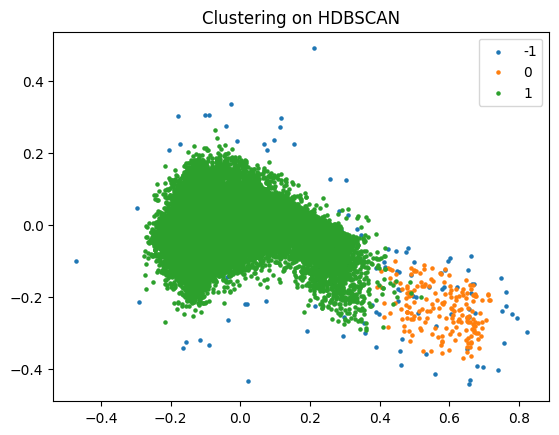

In [11]:
import matplotlib.pyplot as plt

labels = hdb.labels_

u_labels = np.unique(labels)

for i in u_labels:
  filterlabel = X_reduc[labels==i]
  plt.scatter(filterlabel[1], filterlabel[2], s = 5, label = i)

plt.title("Clustering on HDBSCAN")
plt.legend()
plt.show()

HDBSCAN gave a fantastic performance with the ability to develop clusters as visualized but also being the fastest algorithm of the bunch. We can see that it selected the dense group very tightly, but still maintained the smaller grouping on the bottom right.

This can be further bolstered by having the strongest Sillhouette Score of the bunch.

There is still room for improvement, as compared to the baseline clustering, we can see that there is still a clustering group that isn't accounted that could be represented by larger survey of hyperparamters in HDBSCAN.

## Clustering using K-Means:
---

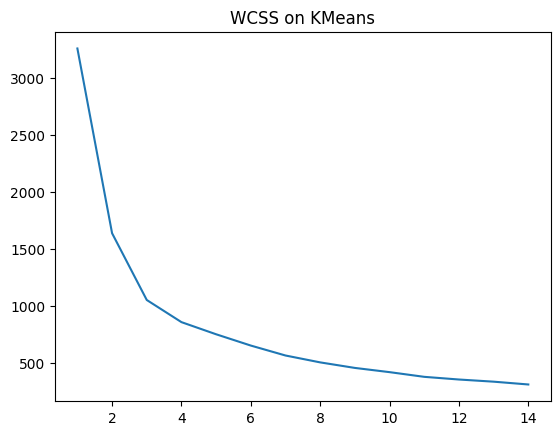

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss_under = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init="auto")
    kmeans.fit(X)
    wcss_under.append((i, kmeans.inertia_))

plt.title("WCSS on KMeans")
plt.plot(*zip(*wcss_under))

From the plot of the Within Cluster Sum of Squares (Inertia) of K-Means, we can see that the ideal clustering (k) value is 3. We can then plug this into clustering algorithm itself to obtain relevant clustering statistics.

This is an interesting value since we know before hand that there are explicitly 3 classes labelled within this dataset, so we can feel confident that there are atleast the correct set of clusters visualized within the dataset, without any explicit labelling.  

In [ ]:
from sklearn.metrics import silhouette_score

opt_k = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42, n_init="auto")
opt_k.fit(X_reduc)

score = silhouette_score(X_reduc, opt_k.labels_)

print("Silhouette Score:", score)

Silhouette Score: 0.44248001936826714


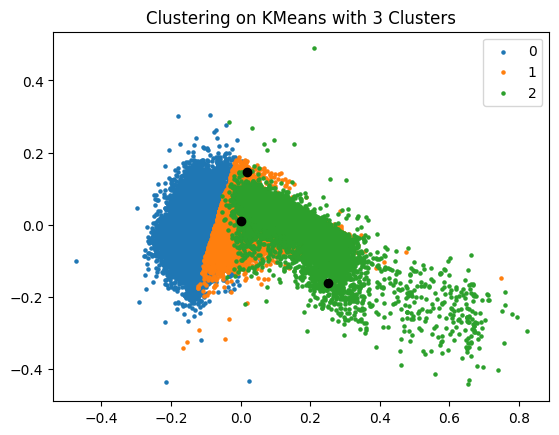

In [ ]:
labels = opt_k.predict(X_reduc)
centroids = opt_k.cluster_centers_

u_labels = np.unique(labels)

for i in u_labels:
  filterlabel = X_reduc[labels==i]
  plt.scatter(filterlabel[1], filterlabel[2], s = 5, label = i)

plt.scatter(centroids[1], centroids[2], color = "black" )


plt.title("Clustering on KMeans with 3 Clusters")
plt.legend()
plt.show()

KMeans actually performs better than expected giving the varying densities within the data, with a grouping that does a decent job of capturing clusters within the dataset.

## Clustering using Gaussian Mixture Model

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture


#Model
gmm = GaussianMixture(n_components=3)
gmm

#Fit the model
gmm.fit(X_test)

#Predict cluster assignments
cluster_assignments = gmm.predict(X_test)
cluster_assignments

cluster_p = gmm.predict_proba(X_test)
cluster_p


# silhouette score
print("Silhouette Score", silhouette_score(X_test, cluster_assignments))

X_test["cluster"] = cluster_assignments



TypeError: ignored

Based on silhouette score, the gaussian mixture model's clustering abililty is a bit compromised as data points could potentially overlap with other clusters. One could approach improving the score by finding the optimal number of clusters or use different ensemble techniques.

# Conclusion



In conclusion we were able to utilize various clustering techniques to our Stellar Data set and find proper partition between our data.  Our intial approach after clean and preparing the data was to undersample in order to create a balance spread through our plane to bring more visibilty to our cluster techniques.  

We used PCA to identify key features to reduce complexity and computational time.  The clustering methods we used were OPTICS, DBSCAN, HDSBCAN, K-Means and Gausian Mixture model.

OPTICS: Silhouette Score: 0.45298289651215007

DBSCAN: Sillhouette Score: 0.4751362270137017

HDBSCAN: Silhouette Score: 0.544559151622201

K-Means: Silhouette Score: 0.44248001936826714



HDBSCAN retrieved the best silhoutte score as well as provided us with the best performance in contrary to DBSCAN which gave the least best performance.  We constantly kept our suitable number for clusters to 3 as it clustered our 3 classes.  In comparison to the other clustering methods HDBSCAN provided the best performance as well as the best Silhoute score.

Interested parties will find our models useful since we can adequately measure several aspects in terms of clustering based on our classes.  The best way to deploy our models for interested parties would be through a projected dashboard compiled with all our python backended code.  The more data we collect would make our models more robust and will definetly improve our approach.  Updating the model periodically would benefit interested parties in research.  As new data is ingested we would be able to synchronize our models as well as graphs and dashboards.
